# Backpropagation from Scratch in Python

**Training a Neural Network to mimic the sine function using pure NumPy**

This jupyter notebook intends to be a hands-on tutorial for the implementation of a simple MLP with backpropagation. The neural network is trained to mimic the sin function from data. Special focus is on the backward pass which is just a special case of reverse-mode automatic differentiation

Simplifications:
- No train-val-test split
- No regularization
- No Stochastic Minibatching
- Simple Gradient Descent with constant learning rate
- No training modifications

---

Given:

- $x \in \Re^{N \times 1}$ and $y \in \Re^{N \times 1}$ (N pairs of (x, y) samples that somehow follow a sine curve)
- weight matrices and biases with the correct shapes
- sigmoid activation function $\sigma(x) = \frac{1}{1 + e^{-x}}$

-> The sigmoid activation function has a nice property that its derivative can
expressed using the primal output

$$
\sigma ' (x) = \sigma(x) (1 - \sigma(x))
$$

Notice the convention of the data matrices being batch x spatial. As such, weight matrices have to be right-multiplied in order to affect the spatial dimensions.

---

### Forward Pass

$$
\begin{aligned}
y_1 &= x \cdot W_1
\\
\tilde{y}_1 &= y_1 + b_1
\\
\hat{y}_1 &= \sigma(\tilde{y}_1)
\end{aligned}
$$

$$
\begin{aligned}
y_2 &= \hat{y}_1 \cdot W_2
\\
\tilde{y}_2 &= y_2 + b_2
\\
\hat{y}_2 &= \sigma(\tilde{y}_2)
\end{aligned}
$$

$$
\begin{aligned}
y_3 &= \hat{y}_2 \cdot W_3
\\
\tilde{y}_3 &= y_3 + b_3
\\
\hat{y}_3 &= \sigma(\tilde{y}_3)
\end{aligned}
$$

$$
\begin{aligned}
y_4 &= \hat{y}_3 \cdot W_4
\\
\tilde{y}_4 &= y_4 + b_4
\\
\hat{y}_4 &= I(\tilde{y}_3)
\end{aligned}
$$

$$
L = \frac{1}{2} \text{mean\_over\_all\_axes}((\hat{y}_4 - y)^2)
$$

---

### Weight Initiliazation

(Xavier Glorot Uniform init)

$$
\begin{aligned}
W_{i,kl} &\propto \mathcal{U}(-lim, lim)
\\
lim &= \sqrt{\frac{6}{\text{fan\_in}_i + \text{fan\_out}_i}}
\\
b_{i,k} &= 0
\end{aligned}
$$

---

### Backward Pass

(Run Forward Pass and save all **activated layer states**)

$$
\begin{aligned}
\bar{L} &= 1.0
\\
\bar{\hat{y}}_4 &= \bar{L} \frac{\hat{y}_4 - y}{N}
\end{aligned}
$$

$$
\begin{aligned}
\bar{\tilde{y}}_4 &= \bar{\hat{y}_4} \odot 1
\\
\bar{b}_4 &= \text{sum\_over\_batch}(\bar{\tilde{y}}_4)
\\
\bar{y}_4 &= \bar{\tilde{y}}_4
\\
\bar{\hat{y}}_3 &= \bar{y}_4 \cdot W_4^T
\\
\bar{W}_4 &= \bar{y}_4 \cdot \hat{y}_3^T%
\end{aligned}
$$

$$
\begin{aligned}
\bar{\tilde{y}}_3 &= \bar{\hat{y}_3} \odot \hat{y}_3 \odot (1 - \hat{y}_3)
\\
\bar{b}_3 &= \text{sum\_over\_batch}(\bar{\tilde{y}}_3)
\\
\bar{y}_3 &= \bar{\tilde{y}}_3
\\
\bar{\hat{y}}_2 &= \bar{y}_3 \cdot W_3^T
\\
\bar{W}_3 &= \bar{y}_3 \cdot \hat{y}_2^T
\end{aligned}
$$

$$
\begin{aligned}
\bar{\tilde{y}}_2 &= \bar{\hat{y}_2} \odot \hat{y}_2 \odot (1 - \hat{y}_2)
\\
\bar{b}_2 &= \text{sum\_over\_batch}(\bar{\tilde{y}}_2)
\\
\bar{y}_2 &= \bar{\tilde{y}}_2
\\
\bar{\hat{y}}_1 &= \bar{y}_2 \cdot W_2^T
\\
\bar{W}_2 &= \bar{y}_2 \cdot \hat{y}_1^T
\end{aligned}
$$

$$
\begin{aligned}
\bar{\tilde{y}}_1 &= \bar{\hat{y}_1} \odot \hat{y}_1 \odot (1 - \hat{y}_1)
\\
\bar{b}_1 &= \text{sum\_over\_batch}(\bar{\tilde{y}}_1)
\\
\bar{y}_1 &= \bar{\tilde{y}}_1
\\
&\left[ \bar{x} = \bar{y}_1 \cdot W_1^T \right]
\\
\bar{W}_1 &= \bar{y}_1 \cdot x^T
\end{aligned}
$$

---

### Learning:

Approximately solve a non-convex optimization problem in the parameter space from a randomized initial estimate.

1. Initialize weights and biases
2. Run forward **and** backward pass (here for all samples together - no minibatching)
3. Update each parameter with its gradient, e.g., $W_1 \leftarrow W_1 - \eta \bar{W}_1$
4. Repeat until loss is sufficiently decreased

## More details on the backward pass:

We used the following primitive pullback/vJp/backprop/adjoint(¹) rules

1. Pullback from loss cotangent to guess cotangent ($\bar{L} \rightarrow \bar{\hat{y}}_4$)
2. Pullback over broacasted function activation ($\bar{\hat{y}}_i \rightarrow \bar{\tilde{y}}_i$)
3. Pullback over batch broadcast vector addition ($\bar{\tilde{y}}_i \rightarrow \bar{b}_i$)
4. Pullback over addition ($\bar{\tilde{y}} \rightarrow \bar{y}_i$)
5. Pullback over matrix-vector (or here matrix-matrix) multiplication ($\bar{y}_i \rightarrow \bar{\hat{y}}_{i-1}$)
6. Pullback over matrix-vector (or here matrix-matrix) multiplication into the matrix ($\bar{y}_i \rightarrow \bar{W}_i$)

Operation (3) and (6) map back into the parameter space. Hence, those are the final ones, giving gradients. The other operations let the *cotangents flow reversely over the computational graph*.

If you want more details, on why these rules are the way they are, here are more interesting videos on their derivation:


1. Loss to guess
    1. Pullback of L2 Loss: https://youtu.be/TonUAqYCWAY
    2. Pullback of a (mean) aggregator, similar to scalar multiplication: https://youtu.be/ho8v1FpoaEg
2. Pullback over broadcasted function: https://youtu.be/bLE6xsVSTUs
3. Over addition
    1. Pullback over scalar addition (holds also for vector and matrix addition): https://youtu.be/SY2ga4ylwVM
    2. Pullback over a scather operation: The reverse will just be the sum the cotangents over the scattered xis
4. Pullback over scalar addition (holds also for vector and matrix addition):https://youtu.be/SY2ga4ylwVM
5. Over Matrix-Vector product
    1. Pullback over a matrix-vector product: https://youtu.be/lqIhocjJLUc
    2. (More precisely we do a matrix-matrix product to account for batching): https://youtu.be/O5YealZxi68
6. Over Matrix-Vector product
    1. Pullback over a matrix-vector product: https://youtu.be/lqIhocjJLUc
    2. (More precisely we do a matrix-matrix product to account for batching): https://youtu.be/O5YealZxi68


(¹): The idea of how NNs obtain their parameter gradients in a backward pass is
a concept found in many disciplines of science. Hence, the history is filled
with multiple re-inventions
(https://en.wikipedia.org/wiki/Backpropagation#History) and namings vary.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In [3]:
N_SAMPLES = 200
LAYERS = [1, 10, 10, 10, 1]
LEARNING_RATE = 0.1
N_EPOCHS = 30_000

In [4]:
# Python convention is batch x spatial
x_samples = np.random.uniform(low=0.0, high=2 * np.pi, size=(N_SAMPLES, 1))
y_samples = np.sin(x_samples) + np.random.normal(loc=0.0, scale=0.3, size=(N_SAMPLES, 1))

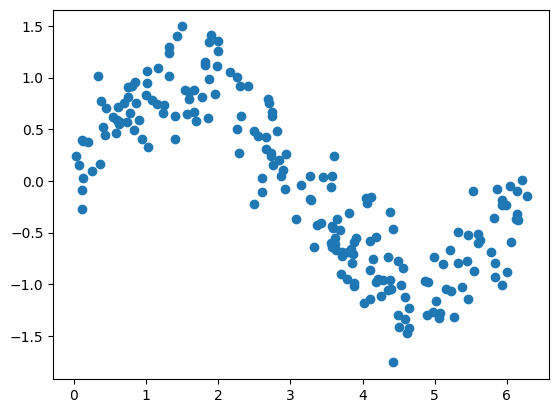

In [5]:
plt.scatter(x_samples, y_samples)

In [6]:
# Activation functions
sigmoid = lambda x: 1 / (1 + np.exp(-x))
identity = lambda x: x

In [7]:
# Initialization of weights and biases
weight_matrices = []
bias_vectors = []
activation_functions = []

for (fan_in, fan_out) in zip(LAYERS[:-1], LAYERS[1:]):
    kernel_matrix_uniform_limit = np.sqrt(6 / (fan_in + fan_out))

    # Glorot uniform initialization
    W = np.random.uniform(
        low=-kernel_matrix_uniform_limit,
        high=+kernel_matrix_uniform_limit,
        size=(fan_in, fan_out),
    )

    # Zero bias initialization
    b = np.zeros(fan_out)

    weight_matrices.append(W)
    bias_vectors.append(b)
    activation_functions.append(sigmoid)

activation_functions[-1] = identity

In [8]:
def network_forward(x, weights, biases, activations):
    a = x

    for W, b, f in zip(weights, biases, activations):
        a = a @ W
        a = a + b
        a = f(a)
    
    return a

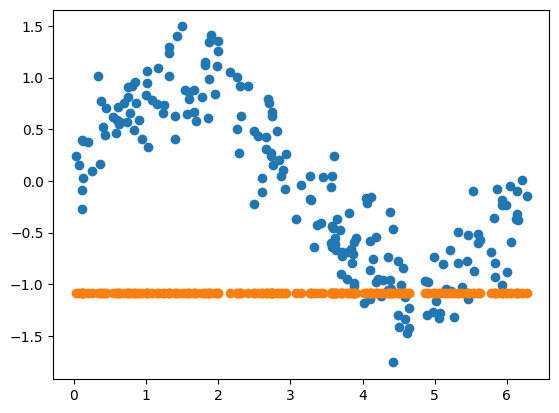

In [9]:
plt.scatter(x_samples, y_samples)
plt.scatter(x_samples, network_forward(x_samples, weight_matrices, bias_vectors, activation_functions))

In [10]:
def loss_forward(y_guess, y_ref):
    delta = y_guess - y_ref
    return 0.5 * np.mean(delta**2)

In [11]:
loss_forward(
    network_forward(x_samples, weight_matrices, bias_vectors, activation_functions),
    y_samples,
)

0.8150125501544493

In [12]:
def loss_backward(y_guess, y_ref):
    delta = y_guess - y_ref
    N = delta.size
    return delta / N

In [13]:
def network_forward_and_backward(x, y_ref, weights, biases, activations, activations_derivatives):
    a = x

    # Store the intermediate activated states for the backward pass
    layer_states = [a, ]

    for W, b, f in zip(weights, biases, activations):
        a = a @ W
        a = a + b
        a = f(a)
        layer_states.append(a)
    
    y = a

    loss = loss_forward(y, y_ref)

    current_cotangent = loss_backward(y, y_ref)

    weight_gradients = []
    bias_gradients = []

    for W, f_prime, a_current, a_prev in zip(
        reversed(weights),
        reversed(activations_derivatives),
        reversed(layer_states[1:]),
        reversed(layer_states[:-1]),
    ):
        activated_state_cotangent = current_cotangent
        plus_bias_state_cotangent = activated_state_cotangent * f_prime(a_current)

        bias_grad = np.sum(plus_bias_state_cotangent, axis=0)

        state_cotangent = plus_bias_state_cotangent

        prev_activated_state_cotangent = state_cotangent @ W.T

SyntaxError: invalid syntax (1421862268.py, line 37)